# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data

In [4]:
sentiment = pd.read_csv('C:/Users/KIIT0001/Desktop/MAHASWETA/Internshala/fear_greed_index.csv')
trades = pd.read_csv('C:/Users/KIIT0001/Desktop/MAHASWETA/Internshala/historical_data.csv')

In [5]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [8]:
sentiment.dtypes

timestamp          int64
value              int64
classification    object
date              object
dtype: object

In [6]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [9]:
trades.dtypes

Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

# Clean data

In [12]:
# Convert timestamps

sentiment['date'] = pd.to_datetime(sentiment['date'], dayfirst=True)
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M")

In [13]:
# Merge on date

trades['date'] = trades['Timestamp IST'].dt.date
sentiment['date'] = sentiment['date'].dt.date
merged = pd.merge(trades, sentiment[['date', 'classification']], on='date', how='left')

# Feature engineering

In [14]:
# Clean column names

merged.rename(columns={
    'Closed PnL': 'closed_pnl',
    'Size USD': 'size_usd',
    'Execution Price': 'execution_price',
    'Side': 'side',
    'Coin': 'coin'
}, inplace=True)

In [17]:
# Add win/loss flag
# used to create a new boolean column called profitable
# If it's greater than 0 → True → it’s a profitable trade
# If it’s 0 or negative → False → it’s a loss 

merged['profitable'] = merged['closed_pnl'] > 0

# EDA

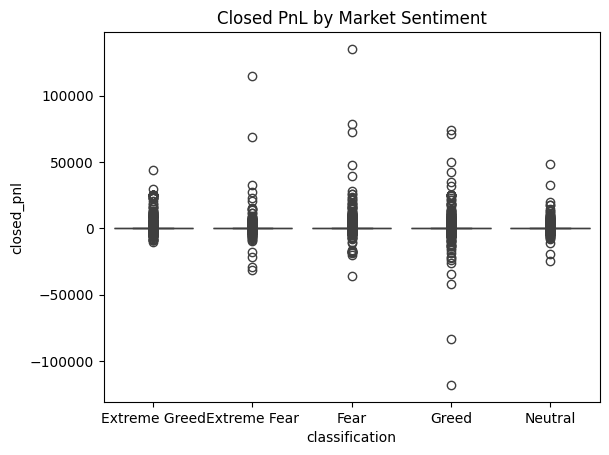

In [18]:
# PnL by sentiment

# Greed tends to produce higher median profits with tighter distribution.
# Fear shows wider variability and more extreme losses, signaling unstable or risky behavior.

sns.boxplot(data=merged, x='classification', y='closed_pnl')
plt.title('Closed PnL by Market Sentiment')
plt.show()

In [19]:
# Win rate

# Win rate refers to the percentage of trades that were profitable out of the total number of trades.
# In simple terms:
# Win Rate = (Number of Profitable Trades / Total Trades) × 100
# So if a trader made 100 trades and 62 were profitable, the win rate is 62%. 
# It’s a quick indicator of how often trades result in gains rather than losses.

win_rate = merged.groupby('classification')['profitable'].mean().reset_index()
print(win_rate)

  classification  profitable
0   Extreme Fear    0.370607
1  Extreme Greed    0.464943
2           Fear    0.420768
3          Greed    0.384828
4        Neutral    0.396991


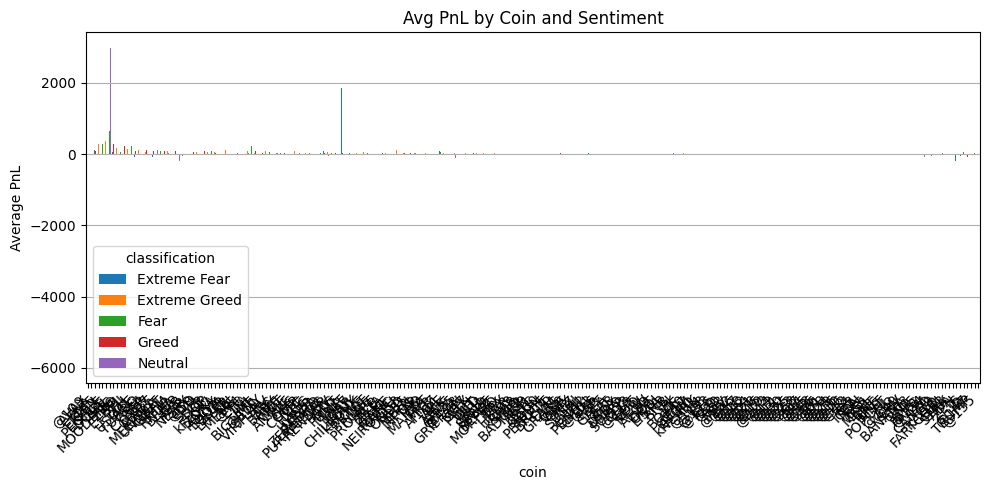

In [21]:
# Coin-wise performance

# This bar plot highlights how trader profitability varies not just with market sentiment, but also across individual coins.

coin_order = merged.groupby('coin')['closed_pnl'].mean().sort_values(ascending=False).index
coin_perf = merged.groupby(['coin', 'classification'])['closed_pnl'].mean().unstack().loc[coin_order]

coin_perf.plot(kind='bar', figsize=(10, 5), title='Avg PnL by Coin and Sentiment')
plt.ylabel('Average PnL')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

# Clustering traders

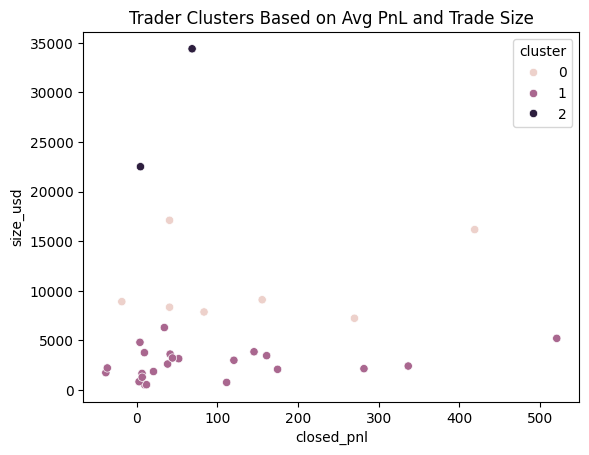

In [22]:
from sklearn.cluster import KMeans

features = merged.groupby('Account')[['closed_pnl', 'size_usd']].mean()
kmeans = KMeans(n_clusters=3, random_state=42).fit(features)
features['cluster'] = kmeans.labels_

sns.scatterplot(data=features, x='closed_pnl', y='size_usd', hue='cluster')
plt.title('Trader Clusters Based on Avg PnL and Trade Size')
plt.show()

# Time series Analysis

In [23]:
# Visualize how market sentiment fluctuates over time

sentiment_ts = sentiment.copy()
sentiment_ts['date'] = pd.to_datetime(sentiment_ts['date'])
sentiment_ts.set_index('date', inplace=True)

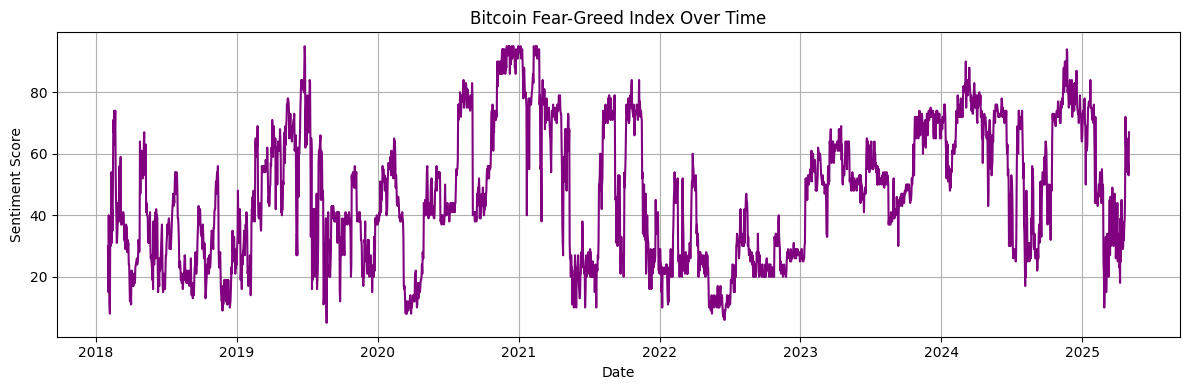

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(sentiment_ts['value'], color='purple')
plt.title('Bitcoin Fear-Greed Index Over Time')
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visuals

C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_10696\2746097617.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_pnl, x='classification', y='closed_pnl', palette='coolwarm')


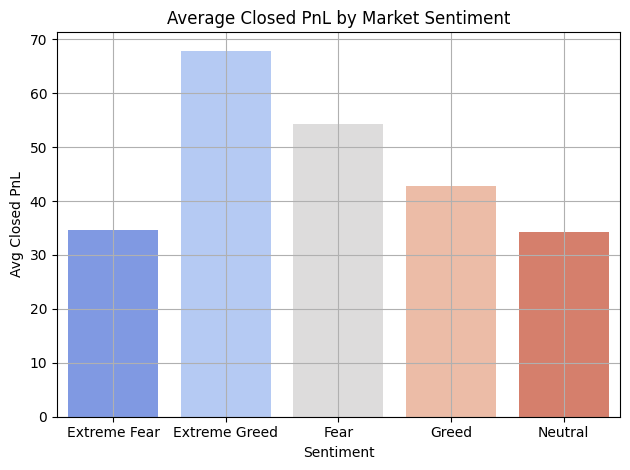

In [25]:
# Average PnL by Sentiment

avg_pnl = merged.groupby('classification')['closed_pnl'].mean().reset_index()

sns.barplot(data=avg_pnl, x='classification', y='closed_pnl', palette='coolwarm')
plt.title('Average Closed PnL by Market Sentiment')
plt.ylabel('Avg Closed PnL')
plt.xlabel('Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()

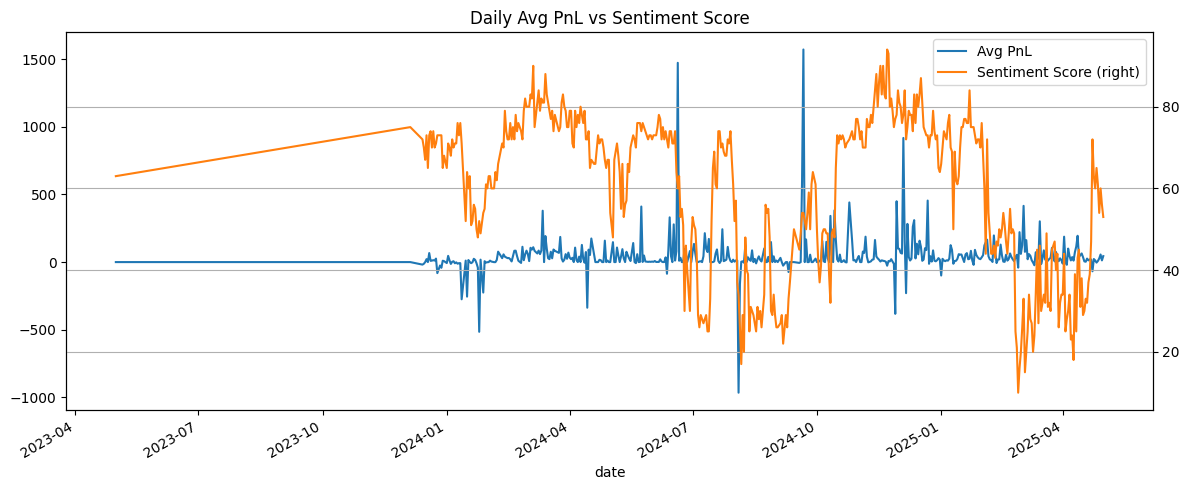

In [26]:
# Daily PnL vs Sentiment Score

daily_pnl = merged.groupby('date')['closed_pnl'].mean()
sentiment_ts = sentiment.set_index(pd.to_datetime(sentiment['date']))
combined = pd.merge(daily_pnl, sentiment_ts['value'], left_index=True, right_index=True)

combined.rename(columns={'closed_pnl': 'Avg PnL', 'value': 'Sentiment Score'}, inplace=True)
combined.plot(figsize=(12, 5), secondary_y='Sentiment Score', title='Daily Avg PnL vs Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_10696\4098116598.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged, x='classification', palette='pastel')


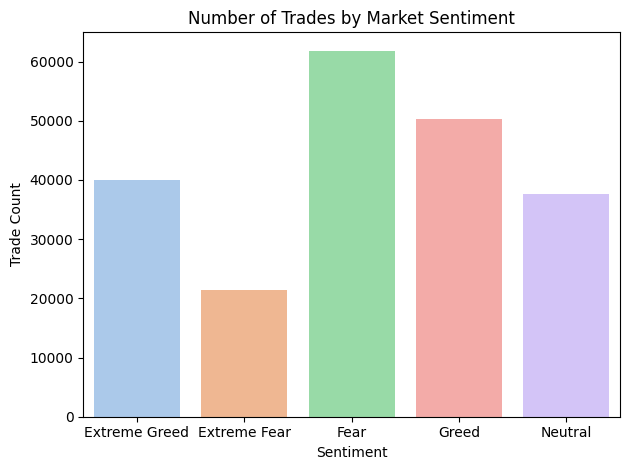

In [27]:
# Number of Trades by Sentiment

sns.countplot(data=merged, x='classification', palette='pastel')
plt.title('Number of Trades by Market Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Trade Count')
plt.tight_layout()
plt.show()

C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_10696\2500870972.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='classification', y='closed_pnl', palette='Set2')


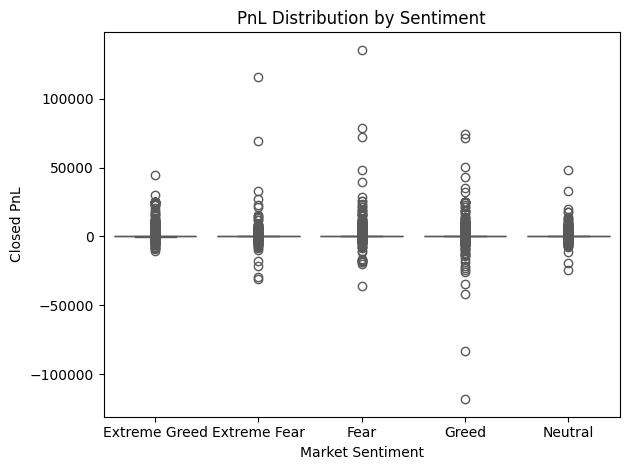

In [28]:
# PnL Distribution by Sentiment

sns.boxplot(data=merged, x='classification', y='closed_pnl', palette='Set2')
plt.title('PnL Distribution by Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.tight_layout()
plt.show()